# Health Insurance Cross-Sell

## Objetivo
Melhorar a ordenação da lista de clientes com maior propensão de compra

# 0.0. IMPORTS

In [1]:
import pandas                       as pd
import numpy                        as np 
import matplotlib.pyplot            as plt
import seaborn                      as sns
from sklearn import model_selection as ms
from sklearn import ensemble        as en

plt.style.use('seaborn-v0_8-whitegrid')



## 0.1. Loading Dataset

In [3]:
df_raw = pd.read_csv( '../data/raw/train.csv')

# 1.0. DATA DESCRIPTION

In [4]:
df1 = df_raw.copy()

## 1.1 Rename Columns To Lowercase

In [5]:
cols_old = ['id', 'Gender', 'Age', 'Driving_License', 'Region_Code',
       'Previously_Insured', 'Vehicle_Age', 'Vehicle_Damage', 'Annual_Premium',
       'Policy_Sales_Channel', 'Vintage', 'Response']

lowercase = lambda x: x.lower()

cols_new = list(map(lowercase, cols_old))

# Renomeando as colunas do DataFrame
df1.columns = cols_new

## 1.2 Data Dimension

In [6]:
print( 'Number of Rows: {}'.format(df1.shape[0]))
print( 'Number of Cols: {}'.format(df1.shape[1]))

Number of Rows: 381109
Number of Cols: 12


## 1.3 Data Types

In [7]:
df1.dtypes

id                        int64
gender                   object
age                       int64
driving_license           int64
region_code             float64
previously_insured        int64
vehicle_age              object
vehicle_damage           object
annual_premium          float64
policy_sales_channel    float64
vintage                   int64
response                  int64
dtype: object

## 1.4 Check NA

In [8]:
df1.isna().sum()

id                      0
gender                  0
age                     0
driving_license         0
region_code             0
previously_insured      0
vehicle_age             0
vehicle_damage          0
annual_premium          0
policy_sales_channel    0
vintage                 0
response                0
dtype: int64

## 1.5 Check Duplicate ID

In [9]:
df1['id'].nunique()

381109

Como o número de ID's corresponde ao número de linhas do dataset, então os ID's são únicos.

## 1.6 Checking Values In Features

In [10]:
df1.nunique().sort_values()

gender                       2
driving_license              2
vehicle_damage               2
previously_insured           2
response                     2
vehicle_age                  3
region_code                 53
age                         66
policy_sales_channel       155
vintage                    290
annual_premium           48838
id                      381109
dtype: int64

- 50% das features têm 2 ou 3 valores únicos.

## 1.7 Checking Percentage Zeros 

In [11]:
features = df1.columns

# Calculando a porcentagem de zeros
percentage_zeros = df1[features].apply(lambda x: (x == 0).mean() * 100)

# Criando dataframe auxiliar
percentage_zeros_df = percentage_zeros.reset_index()
percentage_zeros_df.columns = ['features', 'porcentagem_zeros']

percentage_zeros_df.sort_values('porcentagem_zeros', ascending=False)

,features,porcentagem_zeros
11,response,87.743664
5,previously_insured,54.178988
4,region_code,0.530294
3,driving_license,0.213062
2,age,0.000000
1,gender,0.000000
0,id,0.000000
6,vehicle_age,0.000000
7,vehicle_damage,0.000000
8,annual_premium,0.000000


- Tentei identificar se existia alguma feature com muitos valores zerados, pois isso indica uma baixa variabilidade, o que geralmente é ruim para a modelagem.
- As features 'gender', 'vehicle_damage' e 'vehicle_age' não tem zeros porque seus valores estão em texto em vez de número.

In [12]:
df1.vehicle_damage.value_counts()

vehicle_damage
Yes    192413
No     188696
Name: count, dtype: int64

- É necessário alterar 'Yes' e "No' para 1 e 0.

## 1.8 Descriptive Statistical

In [13]:
num_attributes = df1.select_dtypes( include=['int64', 'float64'])
cat_attributes = df1.select_dtypes( exclude=['int64', 'float64', 'datetime64[ns]'])

In [14]:
# Central Tendency - mean, median
ct1 = pd.DataFrame(num_attributes.apply( np.mean ) ).T
ct2 = pd.DataFrame( num_attributes.apply( np.median ) ).T


# Dispersion - std, min, max, range, skew, kurtosis
d1 = pd.DataFrame( num_attributes.apply( np.std ) ).T
d2 = pd.DataFrame( num_attributes.apply( min ) ).T
d3 = pd.DataFrame( num_attributes.apply( max )  ).T
d4 = pd.DataFrame( num_attributes.apply( lambda x: x.max() - x.min() ) ).T
d5 = pd.DataFrame( num_attributes.apply( lambda x: x.skew() ) ).T
d6 = pd.DataFrame( num_attributes.apply( lambda x: x.kurtosis() ) ).T

# concatenate
metrics = pd.concat( [d2, d3, d4, ct1, ct2, d1, d5, d6]).T.reset_index()
metrics.columns = ['attributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis']
metrics

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,id,1.0,381109.0,381108.0,190555.000000,190555.0,110016.691870,9.443274e-16,-1.200000
1,age,20.0,85.0,65.0,38.822584,36.0,15.511591,6.725390e-01,-0.565655
2,driving_license,0.0,1.0,1.0,0.997869,1.0,0.046109,-2.159518e+01,464.354302
3,region_code,0.0,52.0,52.0,26.388807,28.0,13.229871,-1.152664e-01,-0.867857
4,previously_insured,0.0,1.0,1.0,0.458210,0.0,0.498251,1.677471e-01,-1.971871
5,annual_premium,2630.0,540165.0,537535.0,30564.389581,31669.0,17213.132474,1.766087e+00,34.004569
6,policy_sales_channel,1.0,163.0,162.0,112.034295,133.0,54.203924,-9.000081e-01,-0.970810
7,vintage,10.0,299.0,289.0,154.347397,154.0,83.671194,3.029517e-03,-1.200688
8,response,0.0,1.0,1.0,0.122563,0.0,0.327935,2.301906e+00,3.298788


### Assimetria (Skewness): 
Mede o quanto a distribuição dos dados é desigual em relação à média.

- **Assimetria Positiva**: A cauda da distribuição está para a direita, ou seja, a maioria dos valores estão concentrados no início.
- **Assimetria Negativa**: A cauda da distribuição está para a esquerda, ou seja, a maioria dos valores estão concentrados no final.
- **Assimetria Zero**: A distribuição é simétrica ( distribuição normal ).

### Curtose ( Kurtosis )
Mede o "achatamento" da curva de distribuição dos dados.

- **Curtose Alta**: Distribuição com pico mais acentuado e caudas mais pesadas.
- **Curtose Baixa**: Distribuição mais achatada e caudas mais leves.
- A distribuição normal tem uma curtose de referência (mesocúrtica).

**Nota**: Distribuições muito assimétricas ou com curtose extrema podem afetar o desempenho de alguns modelos de machine learning, especialmente aqueles que assumem normalidade dos dados.

**Observações adicionais**:
1. A assimetria zero indica uma distribuição perfeitamente simétrica, onde a média, mediana e moda são iguais.
2. A curtose da distribuição normal é usada como referência (valor = 3). Distribuições com curtose maior que 3 são chamadas de leptocúrticas, enquanto as com curtose menor que 3 são chamadas de platicúrticas.

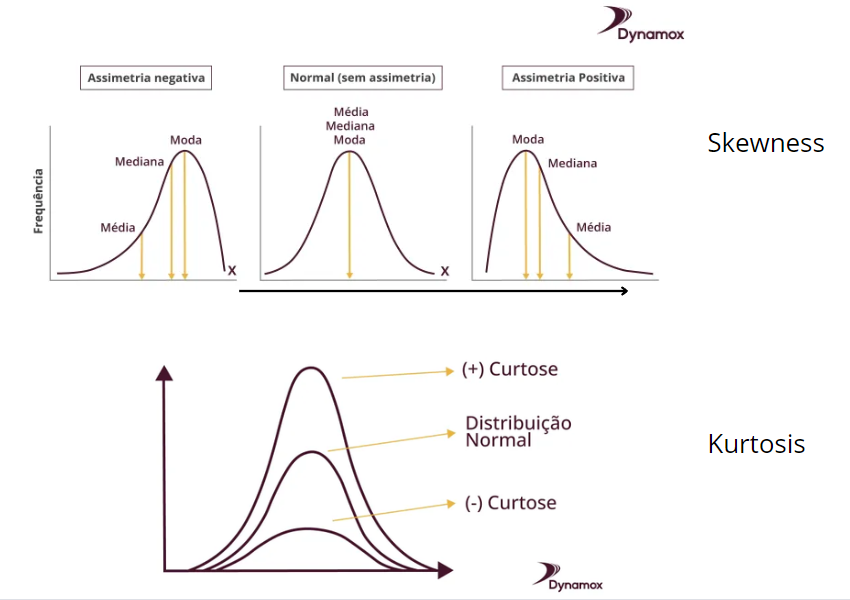

In [15]:
from IPython.display import Image
Image('../references/skew_kurtosis.png')

# 2.0. Feature Engineering

In [16]:
df2 = df1.copy()

In [17]:
# vehicle age
df2['vehicle_age'] = df2['vehicle_age'].apply( lambda x: 'over_2_years' if x =='> 2 Years' else 'between_1_2_years' 
                                                                        if x=='1-2 Year' else 'under_1_year' )

# vehicle damage
df2['vehicle_damage'] = df2['vehicle_damage'].apply( lambda x: 1 if x =='Yes' else 0 )

In [18]:
df2.head()

,id,gender,age,driving_license,region_code,previously_insured,vehicle_age,vehicle_damage,annual_premium,policy_sales_channel,vintage,response
0,1,Male,44,1,28.0,0,over_2_years,1,40454.0,26.0,217,1
1,2,Male,76,1,3.0,0,between_1_2_years,0,33536.0,26.0,183,0
2,3,Male,47,1,28.0,0,over_2_years,1,38294.0,26.0,27,1
3,4,Male,21,1,11.0,1,under_1_year,0,28619.0,152.0,203,0
4,5,Female,29,1,41.0,1,under_1_year,0,27496.0,152.0,39,0


# 3.0. Data Filtering

In [19]:
df3 = df2.copy()

# 4.0. EDA

In [20]:
df4 = df3.copy()

## 4.1 Univariate Analysis

Na classificação estamos procurando variáveis que tem diferenças entre si, para que o meu classificador consiga definir bem o corte no espçao que ele irá realizar na hora de didividir as classes

### 4.1.1 Distribuição das idades por classe

<Axes: xlabel='response', ylabel='age'>

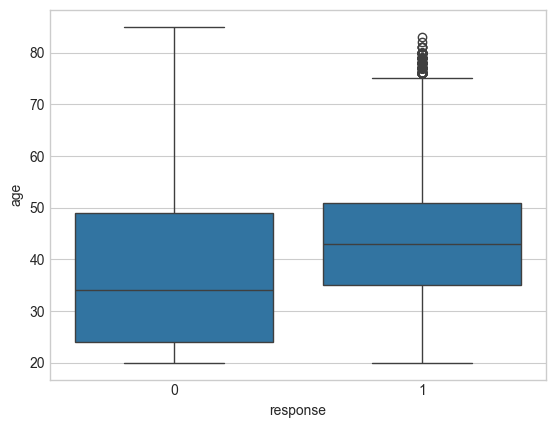

In [21]:
# 'age'
sns.boxplot( x='response', y='age', data=df4 )

<Axes: xlabel='age', ylabel='Count'>

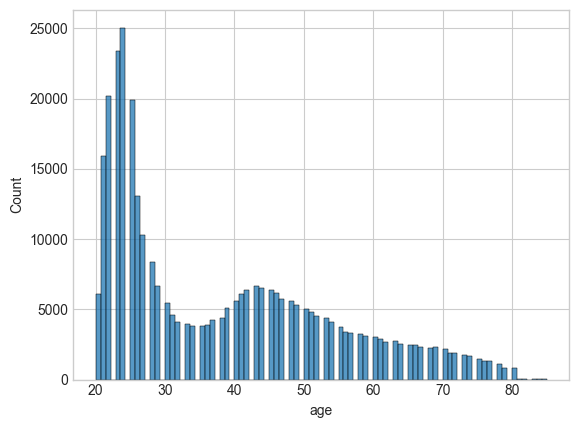

In [22]:
df_aux = df4.loc[df4['response'] == 0, 'age']
sns.histplot( df_aux )

Valores concentrados nas idades iniciais e a cauda da distribuição é para a direita, indicando assimetria positiva

<Axes: xlabel='age', ylabel='Count'>

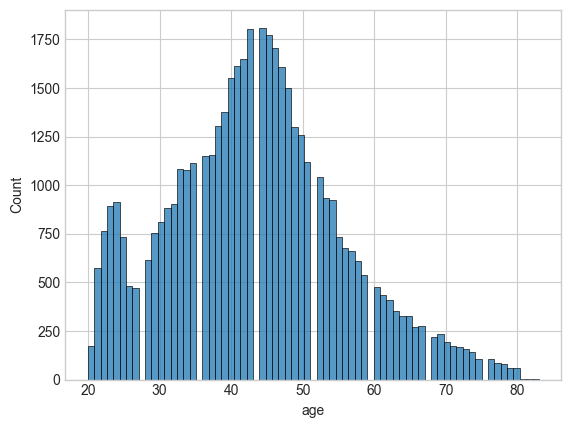

In [23]:
df_aux = df4.loc[df4['response'] == 1, 'age']
sns.histplot( df_aux )

Na classe positiva a distribuição está mais próxima de uma normal.

In [24]:
# 'gender'

In [25]:
# region_code

### Previously Insured

In [26]:
# tabela de contingência
pd.crosstab( df4['previously_insured'], df4['response'] ).apply( lambda x: x / x.sum(), axis=1)



response,0,1
previously_insured,,
0,0.774546,0.225454
1,0.999095,0.000905


- Se a pessoa tem seguro é muito provável que ela não queira outro
- É uma feature que pode ser um **vazamento de dados**

### Vehicle age

In [27]:
# 'vehicle_age'

df4[['vehicle_age', 'response']].value_counts(normalize=True).reset_index()


,vehicle_age,response,proportion
0,between_1_2_years,0,0.434285
1,under_1_year,0,0.413488
2,between_1_2_years,1,0.091328
3,over_2_years,0,0.029663
4,under_1_year,1,0.018897
5,over_2_years,1,0.012338


- over_2_years não tem uma boa discriminação de classes

In [28]:
# vehicle_damage

### Policy sales channel

<Axes: xlabel='response', ylabel='policy_sales_channel'>

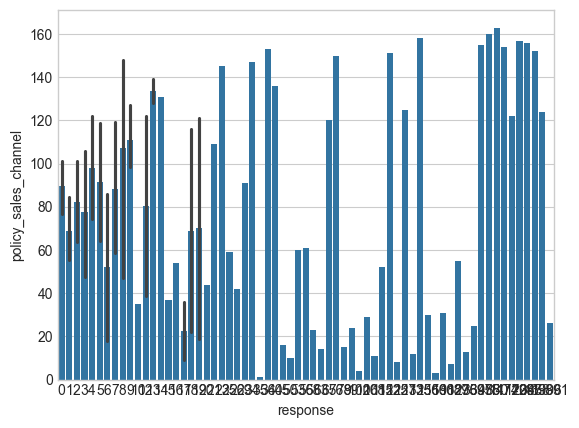

In [29]:
plt.figsize=(20,8)
aux = df4[['policy_sales_channel', 'response']].groupby('policy_sales_channel').sum().reset_index()
sns.barplot( x='response', y='policy_sales_channel', data=aux)



### Vintage

<Axes: xlabel='response', ylabel='vintage'>

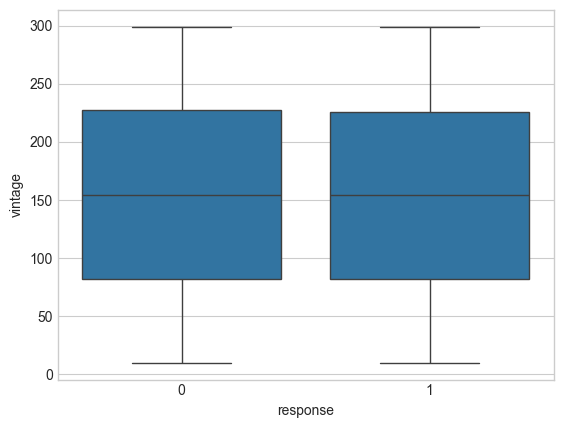

In [30]:
sns.boxplot( x='response', y='vintage', data=df4 )

<Axes: xlabel='vintage', ylabel='Count'>

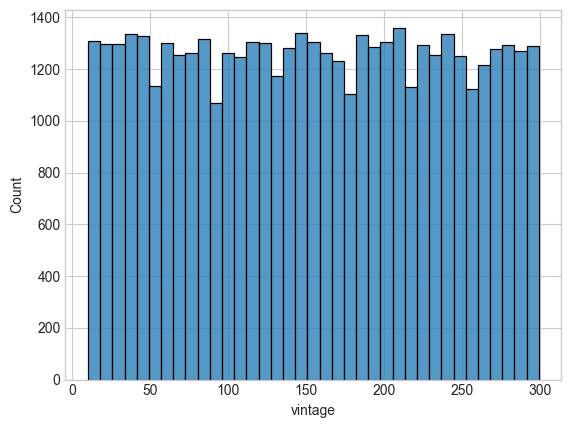

In [31]:
aux = df4.loc[df4['response'] == 1, 'vintage']
sns.histplot( aux )

As duas classes possuem os mesmos gráficos e distribuições nessa variável, ou seja, essa feature não tem nenhuma relevância para a discriminação das classes. 

### Annual Premium

<Axes: xlabel='response', ylabel='annual_premium'>

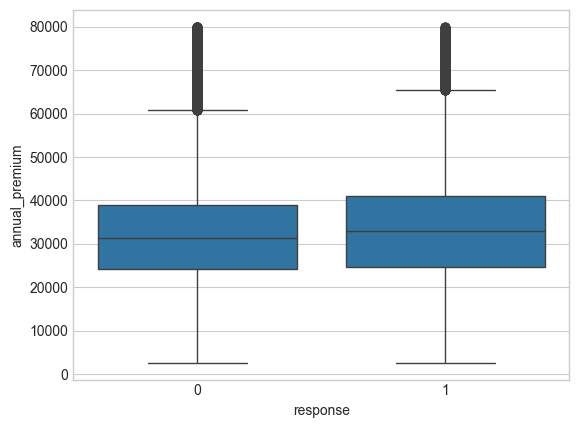

In [32]:
# annual_premium
aux = df4[df4['annual_premium'] < 80000]
sns.boxplot( x='response', y='annual_premium', data=aux )

<Axes: xlabel='annual_premium', ylabel='Count'>

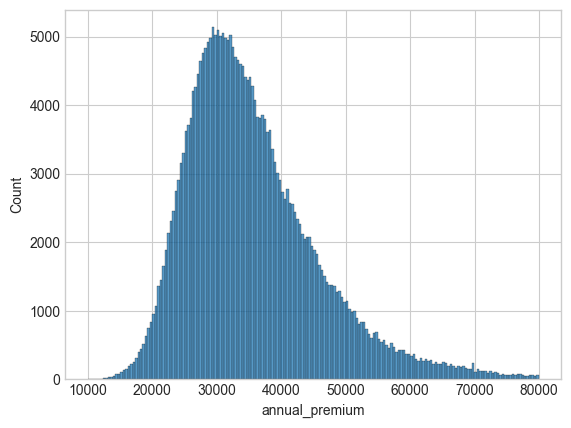

In [33]:
# annual_premium
aux = df4[(df4['annual_premium'] > 10000) & (df4['annual_premium'] < 80000) ]
aux_1 = aux.loc[aux['response'] == 0, 'annual_premium']
sns.histplot(aux_1)

<Axes: xlabel='annual_premium', ylabel='Count'>

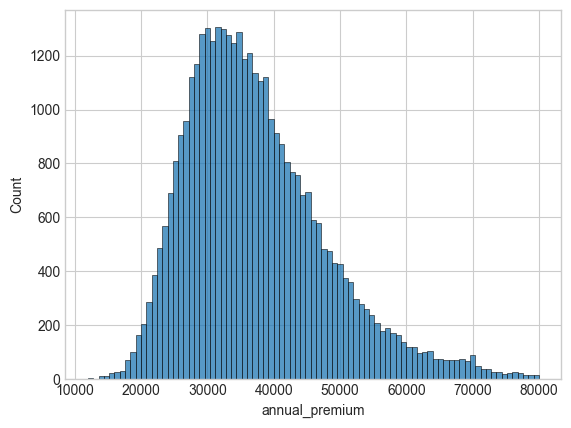

In [34]:
aux_1 = aux.loc[aux['response'] == 1, 'annual_premium']
sns.histplot(aux_1)

- Assim como no boxplot, as distriuições de annual_premium para classe negativa e positiva são bem similares, ou seja, essa feature tem baixo poder discriminatório entre as classes, o que é ruim para o nosso modelo


### Driving License

In [35]:
df4['driving_license'].value_counts(1)


driving_license
1    0.997869
0    0.002131
Name: proportion, dtype: float64

In [36]:
df4.groupby('response')['driving_license'].value_counts()


response  driving_license
0         1                  333628
          0                     771
1         1                   46669
          0                      41
Name: count, dtype: int64

### Region Code

<Axes: xlabel='region_code', ylabel='id'>

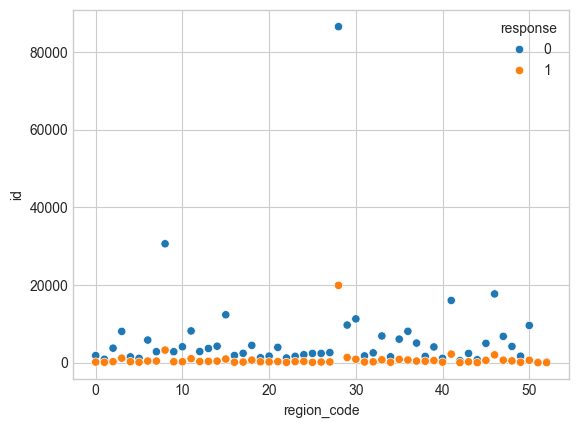

In [37]:
# region code
aux = df4[['id', 'region_code', 'response']].groupby( ['region_code', 'response']).count().reset_index()

sns.scatterplot( x='region_code', y='id', hue='response', data=aux)




In [38]:
# policy_sales_channel

In [39]:
# vintage

In [40]:
# response

# 5.0. Data Preparation

In [41]:
from sklearn.preprocessing import RobustScaler, MinMaxScaler, StandardScaler

df5 = df4.copy()

In [42]:
X = df4.drop( 'response', axis=1 )
y = df4['response'].copy()

x_train, x_validation, y_train, y_validation = ms.train_test_split( X, y, test_size=0.2 )

df5 = pd.concat( [x_train, y_train], axis=1 )

In [43]:
df5.columns

Index(['id', 'gender', 'age', 'driving_license', 'region_code',
       'previously_insured', 'vehicle_age', 'vehicle_damage', 'annual_premium',
       'policy_sales_channel', 'vintage', 'response'],
      dtype='object')

## 5.1 Standardization

In [44]:
scaler = StandardScaler()

df5['annual_premium'] = scaler.fit_transform( df5[['annual_premium']].values )

## 5.2 Rescaling

In [45]:
mms_age = MinMaxScaler()
mms_vintage = MinMaxScaler()

# age
df5['age'] = mms_age.fit_transform( df5[['age']].values )

# vintage
df5['vintage'] = mms_vintage.fit_transform( df5[['vintage']].values )

## 5.3 Encoder

In [46]:
# gender - OHE / Target Encoding
target_encode_gender = df5.groupby( 'gender')['response'].mean()
df5.loc[:, 'gender'] = df5['gender'].map( target_encode_gender )

# region_code - Frequency Encoding / Target Encoding 
target_encode_region_code = df5.groupby( 'region_code' )['response'].mean()
df5.loc[:, 'region_code'] = df5['region_code'].map( target_encode_region_code )

# vehicle_age - OHE / Order Encoding / Frequency Encoding
df5 = pd.get_dummies( df5, prefix='vehicle_age', columns=['vehicle_age'] )

# policy_sales_channel - Target Encoding / Frequency Encoding
fe_policy_sales_channel = df5.groupby( 'policy_sales_channel' ).size() / len( df5 )
df5.loc[:, 'policy_sales_channel'] = df5['policy_sales_channel'].map( fe_policy_sales_channel )




- Region code tem muitas categorias então vou usar Frequency ou Target encoding

## 5.4 Validation Preparation

In [47]:
# gender
x_validation.loc[:, 'gender'] = x_validation.loc[:, 'gender'].map( target_encode_gender )

# age
x_validation.loc[:, 'age'] = mms_age.transform( x_validation[['age']].values)

# region code
x_validation.loc[:, 'region_code'] = x_validation.loc[:, 'region_code'].map( target_encode_region_code)

# vehicle_age
x_validation = pd.get_dummies( x_validation, prefix='vehicle_age', columns=['vehicle_age'])

# annual_premium
x_validation.loc[:, 'annual_premium'] = scaler.transform( x_validation[['annual_premium']].values)

# policy_salves_channel
x_validation.loc[:, 'policy_sales_channel'] = x_validation['policy_sales_channel'].map( fe_policy_sales_channel)

# vintage
x_validation.loc[:, 'vintage'] = mms_vintage.transform( x_validation[['vintage']].values )

# fillna
x_validation = x_validation.fillna( 0 )

C:\Users\Samir\AppData\Local\Temp\ipykernel_4440\1242625080.py:5: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[0.69230769 0.44615385 0.52307692 ... 0.50769231 0.18461538 0.86153846]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  x_validation.loc[:, 'age'] = mms_age.transform( x_validation[['age']].values)
C:\Users\Samir\AppData\Local\Temp\ipykernel_4440\1242625080.py:20: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[0.33910035 0.41176471 0.15224913 ... 0.99307958 0.51557093 0.17647059]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  x_validation.loc[:, 'vintage'] = mms_vintage.transform( x_validation[['vintage']].values )
C:\Users\Samir\AppData\Local\Temp\ipykernel_4440\1242625080.py:23: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfi

# 6.0. Feature Selection

## 6.1 Feature Importance

In [48]:
# model definition
forest = en.ExtraTreesClassifier( n_estimators=250, random_state=0, n_jobs=-1 )

# data preparation
x_train_n = df5.drop( ['id', 'response'], axis=1 )
y_train_n = y_train.values
forest.fit( x_train_n, y_train_n)

ExtraTreesClassifier(n_estimators=250, n_jobs=-1, random_state=0)

Feature ranking:
                          feature  importance
0                         vintage    0.271232
1                  annual_premium    0.243628
2                             age    0.166054
3                     region_code    0.106940
4                  vehicle_damage    0.069093
5            policy_sales_channel    0.059992
6              previously_insured    0.055302
7        vehicle_age_under_1_year    0.012220
8   vehicle_age_between_1_2_years    0.007211
9                          gender    0.004870
10       vehicle_age_over_2_years    0.002955
11                driving_license    0.000502


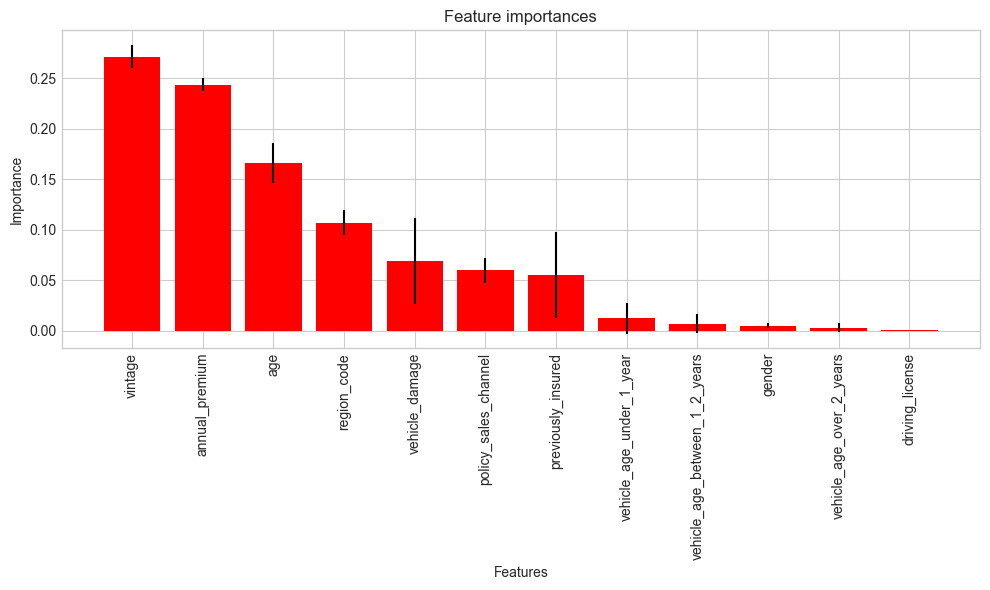

In [49]:
# Calcula a importância das features
importances = forest.feature_importances_

# Calcula o desvio padrão das importâncias entre as árvores
std = np.std([tree.feature_importances_ for tree in forest.estimators_], axis=0)

# Ordena os índices das features por importância (decrescente)
indices = np.argsort(importances)[::-1]

# Cria um DataFrame para armazenar as features e suas importâncias
df = pd.DataFrame({'feature': x_train_n.columns, 'importance': importances})

# Ordena o DataFrame por importância (decrescente) e exibe
print('Feature ranking:')
print(df.sort_values('importance', ascending=False).reset_index(drop=True))

# Cria um gráfico de barras para visualizar as importâncias
plt.figure(figsize=(10, 6))
plt.title('Feature importances')

# Plota as barras de importância
plt.bar(range(x_train_n.shape[1]), importances[indices], 
        color='r', yerr=std[indices], align='center')

# Configura os rótulos do eixo x (nomes das features)
plt.xticks(range(x_train_n.shape[1]), x_train_n.columns[indices], rotation=90)

# Ajusta os limites do eixo x
plt.xlim([-1, x_train_n.shape[1]])

# Adiciona rótulos aos eixos
plt.xlabel('Features')
plt.ylabel('Importance')

# Ajusta o layout e exibe o gráfico
plt.tight_layout()
plt.show()

# 7.0. Machine Learning Modelling

In [50]:
cols_selected = ['vintage', 'annual_premium', 'age', 'region_code', 
'previously_insured', 'policy_sales_channel', 'vehicle_age_under_1_year']

x_train = df5[cols_selected]
x_val = x_validation[cols_selected]
y_val = y_validation.copy()

## 7.1 KNN

In [51]:
from sklearn import neighbors as nh
# model definition
knn_model = nh.KNeighborsClassifier( n_neighbors=3 )

# model training
knn_model.fit( x_train, y_train )

# model prediction - mede o poder de generalização
yhat_knn = knn_model.predict_proba( x_val )

<Axes: title={'center': 'Cumulative Gains Curve'}, xlabel='Percentage of sample', ylabel='Gain'>

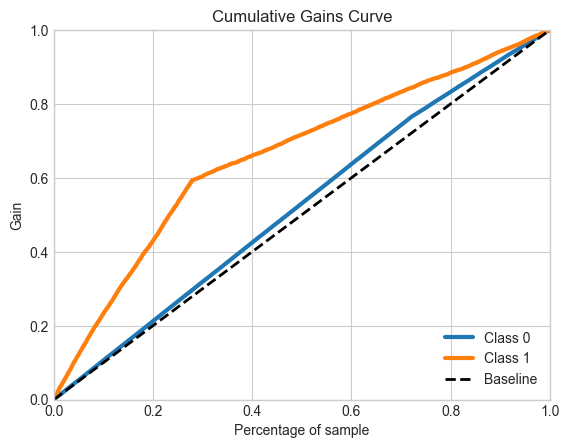

In [52]:
import scipy
scipy.interp = np.interp

import scikitplot as skplt

# Curva de ganho acumulado
skplt.metrics.plot_cumulative_gain( y_val, yhat_knn )

O gráfico da curva de ganho mostra que se a empresa abordar **30%** da amostra da base de dados ordenada pela maior propensão de compra, conseguirá alcançar **60%** dos clientes que estão interessados em comprar o novo seguro.

Quanto maior for a porcentagem de amostras que o meu modelo precisa para alcançar 100% dos interessados, maior será o custo para a empresa. Porque isso significa que a empresa gastará muitos recursos de marketing para entrar em contato com todas elas.

O ideal é que nosso modelo consiga alcançar 100% de pessoas interessadas (Gain) no menor número possível de porcentagem de pessoas. Lembrando que o nosso modelo ordena as amostras pela maior propensão de compra.

O modelo de regresão logística tem uma peformance melhor na ordenação da nossa base de dados. Justamente porque ele consegue alcançar 100% dos clientes interessados com aproximadamente 50% da base de dados ordenada pela propensão de compra.

## Métrica de curva de ganho
- Como resumir em 1 número?

## 7.2 Extra Trees

In [53]:
# model definition
et = en.ExtraTreesClassifier( n_estimators=1000, n_jobs=1, random_state=42 )

# model fit
et.fit( x_train, y_train )

# model predict
yhat_et = et.predict_proba( x_val )

<Axes: title={'center': 'Cumulative Gains Curve'}, xlabel='Percentage of sample', ylabel='Gain'>

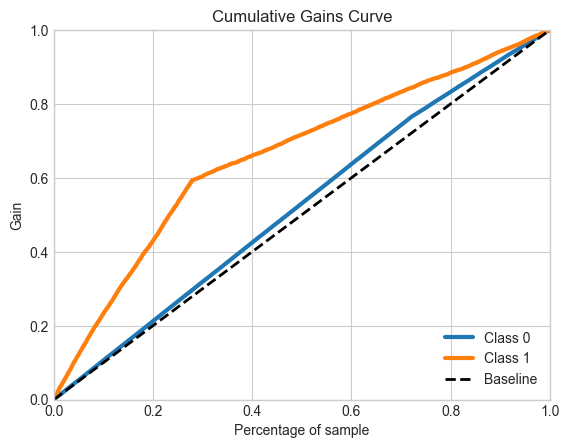

In [54]:
import scipy
scipy.interp = np.interp

import scikitplot as skplt

# Curva de ganho acumulado
skplt.metrics.plot_cumulative_gain( y_val, yhat_knn )

# 8.0 Model Performance

In [55]:
def precision_at_k( data, k=2000 ):
    # reset index
    data = data.reset_index( drop=True )

    # create ranking order
    data['ranking'] = data.index + 1

    # Fazendo a soma acumulada da response e dividindo por cada uma das linhas
    data['precision_at_k'] = data['response'].cumsum() / data['ranking']

    return data.loc[k, 'precision_at_k']

In [56]:
def recall_at_k( data, k=2000 ):
    # reset index
    data = data.reset_index( drop=True )

    # create ranking order
    data['ranking'] = data.index + 1

    # Fazendo a soma acumulada da response e dividindo por cada uma das linhas
    data['recall_at_k'] = data['response'].cumsum() / data['response'].sum()

    return data.loc[k, 'recall_at_k']

In [57]:
# copy data
df8 = x_validation.copy()
df8['response'] = y_validation.copy()

# propensity score
df8['propensity_score'] = yhat_knn[:,1].tolist()

# sorted clients by propensity score
df8 = df8.sort_values( 'propensity_score', ascending=False )

# compute precision at k
precision_at_50 = precision_at_k( df8, k=50 )
print( 'Precision at K: {}'.format( precision_at_50 ) )

# compute recall at k
recall_at_50 = recall_at_k( df8, k=50 )
print( 'Recall at K: {}'.format( recall_at_50))

Precision at K: 0.35294117647058826
Recall at K: 0.0019208195496745277
